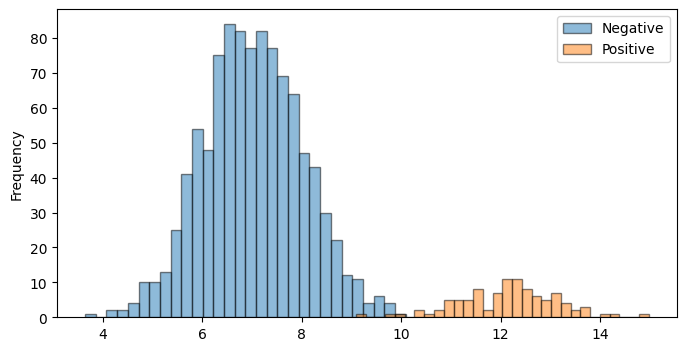

In [1]:
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt

pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))
gini = pd.DataFrame({'value':
np.append((pos_center) + rs.randn(pos_count),
(neg_center) + rs.randn(neg_count)),
'label':
['pos']* pos_count + ['neg'] * neg_count})
fig, ax = plt.subplots(figsize=(8, 4))
_ = (gini
.groupby('label')
[['value']]
.plot.hist(bins=30, alpha=.5, ax=ax, edgecolor='black')
)
ax.legend(['Negative', 'Positive'])

In [3]:
gini.label.value_counts()

label
neg    1000
pos     100
Name: count, dtype: int64

In [2]:
def calc_gini(df, val_col, label_col, pos_val, split_point,debug=False):
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp+fp
    neg_size = tn+fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp/pos_size)**2 - (fp/pos_size)**2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn/neg_size)**2 - (fn/neg_size)**2
    
    weighted_avg = gini_pos * (pos_size/total_size) + \
    gini_neg * (neg_size/total_size)
    if debug:
        print(f'{gini_pos=:.3} {gini_neg=:.3} {weighted_avg=:.3}')
    return weighted_avg

In [3]:
calc_gini(gini, val_col='value', label_col='label', pos_val='pos', split_point=9.24, debug=True)

gini_pos=0.217 gini_neg=0.00202 weighted_avg=0.0241


0.024117224644432264

Text(0.5, 0, 'Split Point')

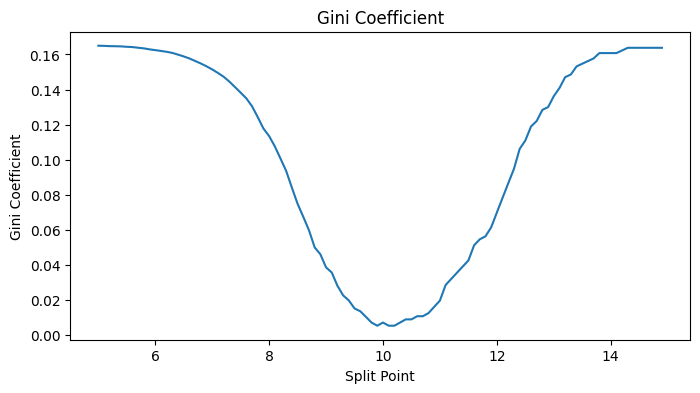

In [4]:
values = np.arange(5, 15, .1)
ginis = []
for v in values:
    ginis.append(calc_gini(gini, val_col='value', label_col='label',
    pos_val='pos', split_point=v))
    
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')

In [5]:
pd.Series(ginis, index=values).loc[9.5:10.5]

9.6     0.013703
9.7     0.010470
9.8     0.007193
9.9     0.005429
10.0    0.007238
10.1    0.005438
10.2    0.005438
10.3    0.007244
10.4    0.009046
10.5    0.009046
dtype: float64

In [6]:
pd.DataFrame({'gini':ginis, 'split':values})

,gini,split
0,0.164968,5.0
1,0.164889,5.1
2,0.164730,5.2
3,0.164682,5.3
4,0.164584,5.4
...,...,...
95,0.163785,14.5
96,0.163785,14.6
97,0.163785,14.7
98,0.163785,14.8


In [7]:
print(pd.DataFrame({'gini':ginis, 'split':values}).query('gini <= gini.min()'))

        gini  split
49  0.005429    9.9


In [8]:
gini

,value,label
0,14.210352,pos
1,12.775662,pos
2,12.346531,pos
3,12.977911,pos
4,13.146511,pos
...,...,...
1095,6.633856,neg
1096,6.116057,neg
1097,6.586057,neg
1098,6.990318,neg


In [9]:
from sklearn import tree
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(gini[['value']], gini.label)


DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'value <= 9.708\ngini = 0.165\nsamples = 1100\nvalue = [1000, 100]\nclass = neg'),
 Text(0.25, 0.25, 'gini = 0.002\nsamples = 999\nvalue = [998, 1]\nclass = neg'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.039\nsamples = 101\nvalue = [2, 99]\nclass = pos'),
 Text(0.625, 0.5, '  False')]

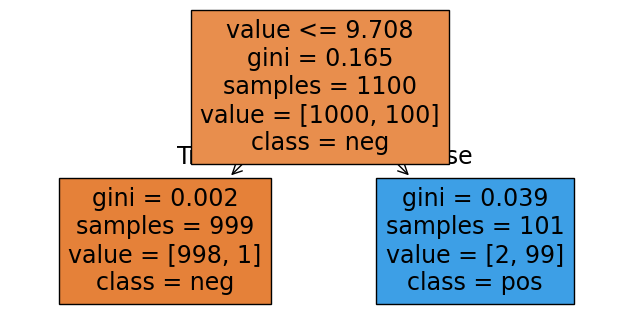

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
tree.plot_tree(stump, feature_names=['value'],
filled=True,
class_names=stump.classes_,
ax=ax)


In [11]:
stump.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [12]:
gini.label == 'pos'

0        True
1        True
2        True
3        True
4        True
        ...  
1095    False
1096    False
1097    False
1098    False
1099    False
Name: label, Length: 1100, dtype: bool

In [13]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import xgboost as xgb
xg_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
xg_stump.fit(gini[['value']], (gini.label== 'pos'))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1,
              n_jobs=None, num_parallel_tree=None, ...)

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Axes: >

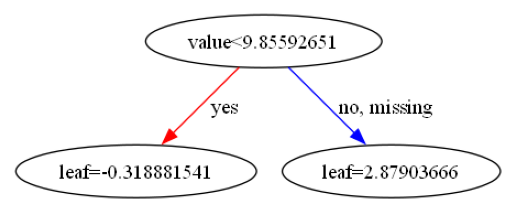

In [15]:
xgb.plot_tree(xg_stump, num_trees=0)

In [17]:
%pip install dtreeviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


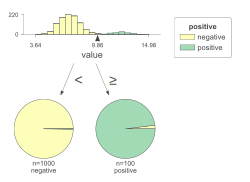

In [18]:
import dtreeviz
viz = dtreeviz.model(xg_stump, X_train=gini[['value']],
y_train=gini.label=='pos',
target_name='positive',
feature_names=['value'], class_names=['negative', 'positive'],
tree_index=0)
viz.view()